In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

## Initializing with the Dirty Image

The core computational process required to synthesize an image with a regularized maximum likelihood (RML) algorithm is an optimization loop (as seen in the [Optimization Tutorial](optimization.html)) powered by gradient descent. In theory, we could start this optimization process from a random or neutral starting point (e.g., a blank image), and with enough iterations of the optimization algorithm, we will eventually converge to the "optimal" image (assuming there is a single, global maximum). If we could choose a "better" starting point, however, we'll need fewer iterations of our optimization loop to converge to the optimal image. A reasonable starting point is the dirty image, since it is already a maximum likelihood fit the data (though of course, it is unregularized).

The problem with the dirty image is that it usually contains negative flux pixels and we'd like to impose the (rather strong) prior that the astrophysical source must have positive intensity values (i.e., no negative flux values are permitted). Image positivity is enforced by default through the [BaseCube](../api.html#mpol.images.BaseCube) parameterization.

So the question is how can we initialize the RML image model to the dirty image if we can't represent negative flux pixels?

This tutorial will demonstrate one initialization solution, which is to create a loss function corresponding to the mean squared error between the RML model image pixel fluxes and the dirty image pixel fluxes and then optimize the RML model. We will also cover how to save and load the starting point configuration. After saving and loading it, it can be then optimized against the visibility data to complete it (though this will not be done in this tutorial). We will use the dataset of the ALMA logo first used in the Gridding and Diagnostic Images tutorial.



### Image Setup

Here we will set up the ALMA Logo image dataset and display it. Consult the [Gridding and Diagnostic Images Tutorial](gridder.html) for reference.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from astropy.utils.data import download_file

In [4]:
from mpol import coordinates, gridding, losses, precomposed, utils

When saving and loading a model, it is important to make sure that ``cell_size``, ``nchan``, and ``npix`` remain the same. More info on coordinates can be found [here](../api.rst#mpol.coordinates.GridCoords).

In [5]:
# load the mock dataset of the ALMA logo
fname = download_file(
    "https://zenodo.org/record/4930016/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# this is a multi-channel dataset... but for demonstration purposes we'll use
# only the central, single channel
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]
data_re = data.real
data_im = data.imag

# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(
    cell_size=0.03, npix=180
)  # Smaller cell size and larger npix value can greatly increase run time
gridder = gridding.Gridder(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = gridder.to_pytorch_dataset()

Now let's calculate the dirty image. Here we're using Briggs weighting with a robust value of 1.0, but you can use whichever weighting scheme you think looks best for your dataset.

In [6]:
# Calculate the dirty image
img, beam = gridder.get_dirty_image(weighting="briggs", robust=1.0, unit="Jy/beam")

Let's visualize this dirty image. Here we're using an aggressive colormap to highlight the many negative flux pixels contained in this image.

<Figure size 480x480 with 0 Axes>

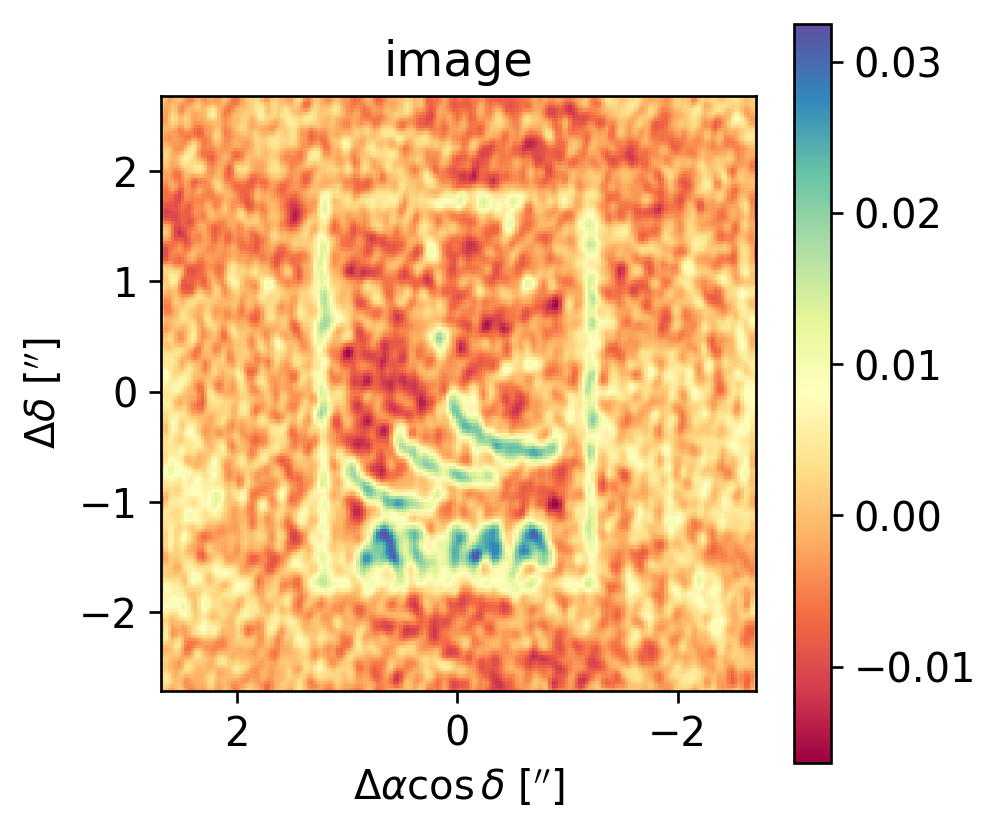

In [7]:
plt.set_cmap(
    "Spectral"
)  # using Matplotlib diverging colormap to accentuate negative values
kw = {"origin": "lower", "extent": gridder.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
snp = ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(snp)

We can see that there are a number of pixels with negative flux values

In [8]:
np.sum(img < 0)

18099

### Model and Optimization Setup

Here we set the optimizer and the image model (RML). If this is unfamiliar please reference the [Optimization tutorial](optimization.html).

In [9]:
dirty_image = torch.tensor(img.copy())  # turns it into a pytorch tensor
rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
optimizer = torch.optim.SGD(
    rml.parameters(), lr=1000.0
)  # multiple different possiple optimizers

### Loss Function

The [loss function](../api.html#module-mpol.losses) that will be used to optimize the initial part of the image is the pixel-to-pixel L2 norm (also known as the Euclidian Norm). It calculates the loss based off of the image-plane distance between the dirty image and the state of the ImageCube in order to make the state of the ImageCube closer to the dirty image. [Pytorch provides a loss function for mean squared error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) which is the squared L2 norm so we will be using the square root of that.

### Training Loop

Now we train using this loss function to optimize our parameters.

In [10]:
loss_tracker = []
for iteration in range(50):

    optimizer.zero_grad()

    rml.forward()

    sky_cube = rml.icube.sky_cube

    lossfunc = torch.nn.MSELoss(
        reduction="sum"
    )  # the MSELoss calculates mean squared error (squared L2 norm), so we take the sqrt of it
    loss = (lossfunc(sky_cube, dirty_image)) ** 0.5

    loss_tracker.append(loss.item())
    loss.backward()
    optimizer.step()
#
# We see that the optimization has completed successfully

Text(0, 0.5, 'loss')

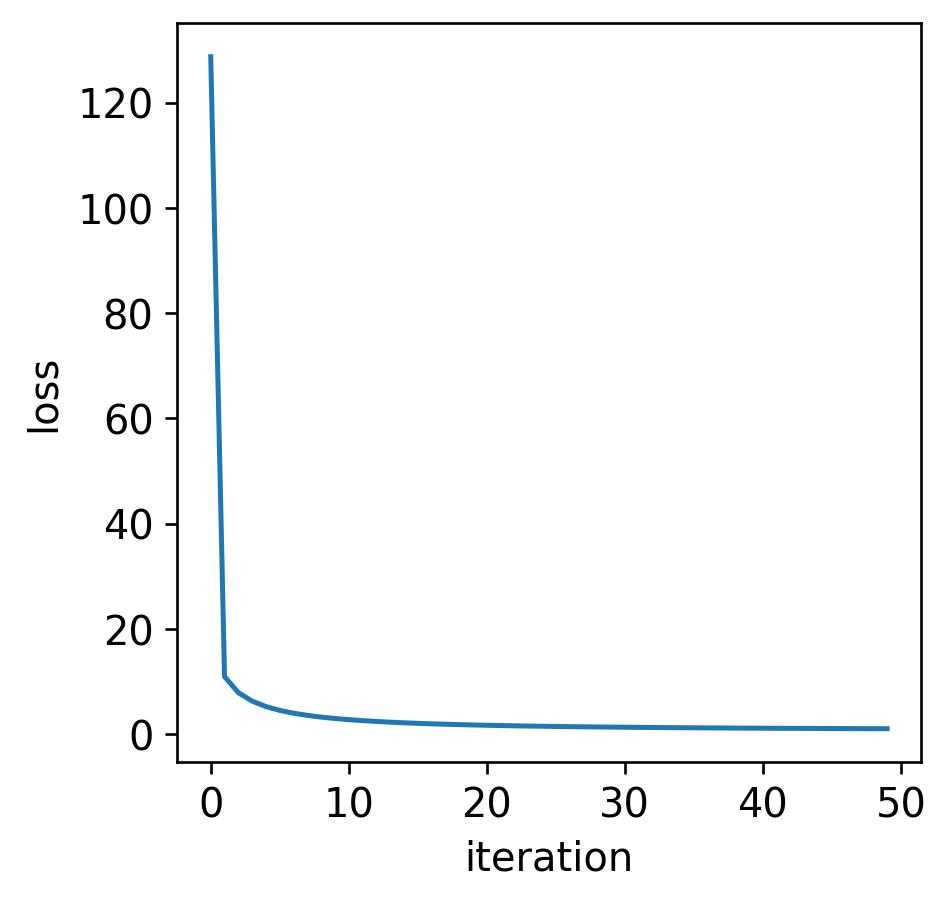

In [11]:
fig, ax = plt.subplots(nrows=1)
ax.plot(loss_tracker)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")

Let's visualize the resulting image cube representation.

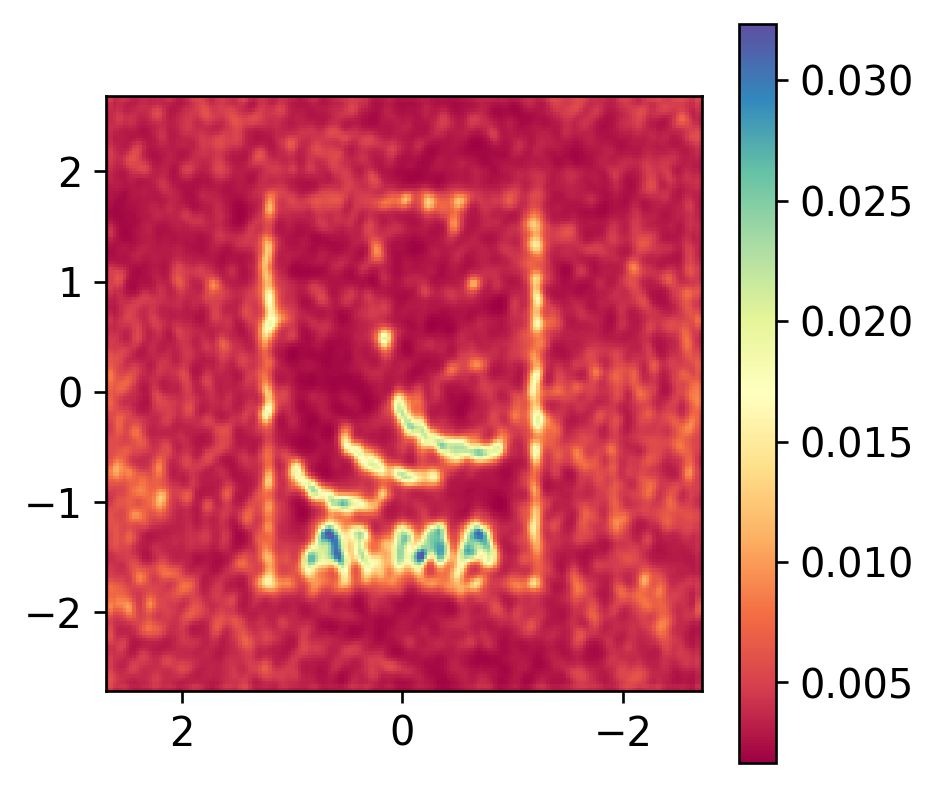

In [12]:
img = np.squeeze(rml.icube.sky_cube.detach().numpy())
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    img, origin="lower", interpolation="none", extent=rml.icube.coords.img_ext
)
plt.colorbar(im)

We see that the cube resembles the dirty image, but it contains no pixels with negative flux values.

In [13]:
np.sum(img < 0)

0

We can also plot this with a normal colormap,

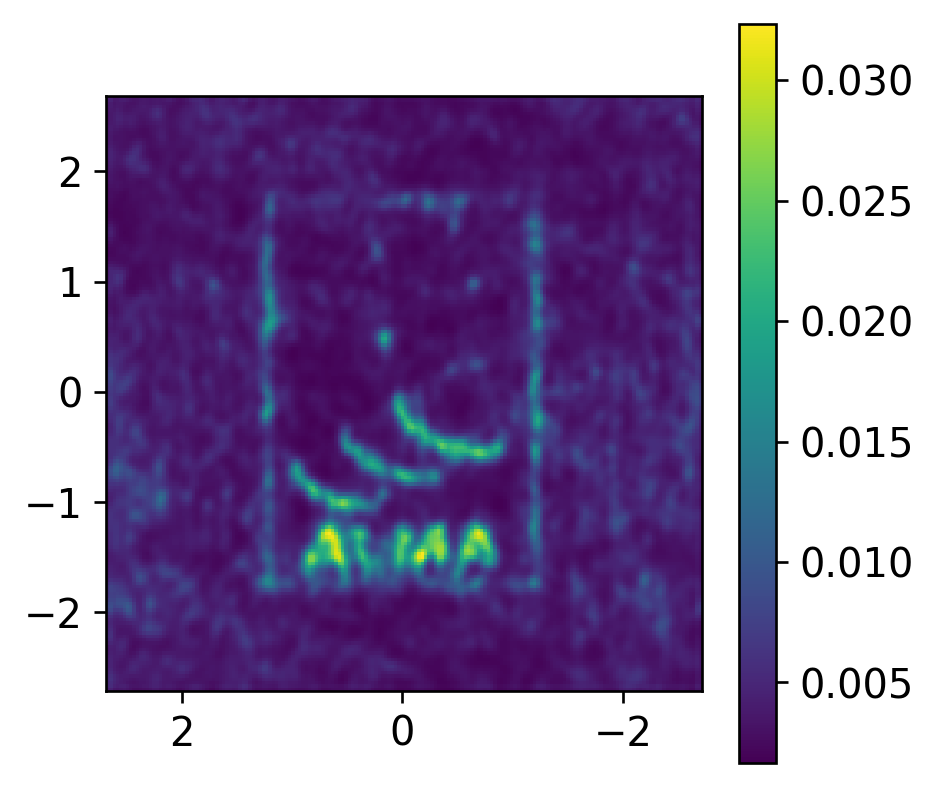

In [14]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    img,
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
    cmap="viridis",
)
plt.colorbar(im)

### Saving the Model

Now that we're happy that the state of the image cube model is approximately initialized to the dirty image, we can save it to disk so that we may easily reuse it in future optimization loops. This is as simple as

In [15]:
torch.save(rml.state_dict(), "dirty_image_model.pt")

For more information on saving and loading models in PyTorch, please consult the official [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

### Loading the Model

Now let's assume we're about to start an optimization loop in a new file, and we've just created a new model.

In [16]:
rml = precomposed.SimpleNet(coords=coords)
rml.state_dict()  # the now uninitialized parameters of the model (the ones we started with)

OrderedDict([('bcube.base_cube',
              tensor([[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       ...,
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

Here you can clearly see the ``state_dict`` is in its original state, before the training loop changed the paramters through the optimization function. Loading our saved dirty image state into the model is as simple as

In [17]:
rml.load_state_dict(torch.load("dirty_image_model.pt"))
rml.state_dict()  # the reloaded parameters of the model

OrderedDict([('bcube.base_cube',
              tensor([[[-5.0804, -4.8556, -5.1265,  ..., -5.4252, -5.4998, -5.3646],
                       [-5.4508, -5.2860, -5.4591,  ..., -5.6400, -5.7612, -5.6770],
                       [-5.6921, -5.5713, -5.6573,  ..., -5.8351, -5.9434, -5.8712],
                       ...,
                       [-4.1607, -3.8701, -3.9250,  ..., -4.8574, -4.7145, -4.4097],
                       [-4.3247, -3.9789, -4.1579,  ..., -4.9576, -4.8731, -4.6139],
                       [-4.6532, -4.3457, -4.6481,  ..., -5.1825, -5.1763, -4.9727]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

Now you can proceed with optimizing the model against the visibility data as before, but you should hopefully have a much better starting point.

### Conclusion

This tutorial shows how to work towards a better starting point for RML optimization by starting from the dirty image. We should note, however, that RML optimization does not *need* to start from the dirty image---it's entirely possible to start from a blank image or even a random image. In that sense, the RML imaging process could be described as an optimization process compared to a [deconvolution process](https://casa.nrao.edu/casadocs/casa-6.1.0/imaging/synthesis-imaging/deconvolution-algorithms#:~:text=Deconvolution%20refers%20to%20the%20process,spread%2Dfunction%20of%20the%20instrument) like [CASA tclean](https://casa.nrao.edu/docs/taskref/tclean-task.html).